In [2]:
import pandas as pd 

In [3]:
df = pd.read_csv('/bigtemp/ahs5ce/CS6501_Projects/Project2/data/locations_w_labels.csv')

In [7]:
df = df[~df['label'].isin(['UNKNOWN', 'SEARCHED_ADDRESS', 'CYCLING', 'WALKING', 'IN_PASSENGER_VEHICLE'])]
df

,Unnamed: 0.1,Unnamed: 0,latitude,longitude,timestamp,label,type,location_name,location_types,place_id,geometry,index_right,polygon_name,Description,date
0,0,0,37.909347,-78.333266,2025-01-27 09:51:00-05:00,Home,timelinePath,"Lake Monticello, VA 22963, USA","locality, political",ChIJDb4p9W2Ns4kRXpzD4FEHVgc,POINT (-78.3332658 37.9093471),2.0,Home,NaN,2025-01-27
1,1,1,37.909347,-78.333266,2025-01-27 10:01:00-05:00,Home,timelinePath,"Lake Monticello, VA 22963, USA","locality, political",ChIJDb4p9W2Ns4kRXpzD4FEHVgc,POINT (-78.3332658 37.9093471),2.0,Home,NaN,2025-01-27
2,2,2,37.909375,-78.333361,2025-01-27 09:51:00-05:00,Home,visit_start,"Lake Monticello, VA 22963, USA","locality, political",ChIJDb4p9W2Ns4kRXpzD4FEHVgc,POINT (-78.3333614 37.9093753),2.0,Home,NaN,2025-01-27
3,3,3,37.909375,-78.333361,2025-01-27 10:01:00-05:00,Home,visit_end,"Lake Monticello, VA 22963, USA","locality, political",ChIJDb4p9W2Ns4kRXpzD4FEHVgc,POINT (-78.3333614 37.9093753),2.0,Home,NaN,2025-01-27
4,4,4,37.909375,-78.333361,2025-01-27 10:01:00-05:00,Home,activity_start,"Lake Monticello, VA 22963, USA","locality, political",ChIJDb4p9W2Ns4kRXpzD4FEHVgc,POINT (-78.3333614 37.9093753),2.0,Home,NaN,2025-01-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4900,4900,4900,38.036998,-78.505514,NaT,Work,timelinePath,"University of Virginia, VA, USA","locality, political",ChIJdzcV_VeGs4kRWFCMy1s4jYg,POINT (-78.505514 38.0369983),0.0,Work,NaN,NaT
4901,4901,4901,38.033553,-78.507977,NaT,Work,visit_start,"University of Virginia, VA, USA","locality, political",ChIJdzcV_VeGs4kRWFCMy1s4jYg,POINT (-78.5079772 38.0335529),0.0,Work,NaN,NaT
4902,4902,4902,38.033553,-78.507977,NaT,Work,visit_end,"University of Virginia, VA, USA","locality, political",ChIJdzcV_VeGs4kRWFCMy1s4jYg,POINT (-78.5079772 38.0335529),0.0,Work,NaN,NaT
4903,4903,4903,38.036359,-78.506090,NaT,Work,visit_start,"University of Virginia, VA, USA","locality, political",ChIJdzcV_VeGs4kRWFCMy1s4jYg,POINT (-78.50609 38.0363594),0.0,Work,NaN,NaT


In [8]:
# df['timestamp'] = pd.to_datetime(df['timestamp'])

df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
print(df['timestamp'].dtype)
# Create a new column for the date (local date)
df['date'] = df['timestamp'].dt.date

# Filter for visit_start (arrival) and visit_end (departure) rows
arrival_df = df[df['type'] == 'visit_start'][['label', 'date', 'timestamp']]
departure_df = df[df['type'] == 'visit_end'][['label', 'date', 'timestamp']]

# For each day and label, get the earliest arrival and the latest departure
daily_arrival = arrival_df.groupby(['label', 'date'])['timestamp'].min().reset_index().rename(columns={'timestamp': 'arrival'})
daily_departure = departure_df.groupby(['label', 'date'])['timestamp'].max().reset_index().rename(columns={'timestamp': 'departure'})

# Merge the daily arrival and departure times
daily = pd.merge(daily_arrival, daily_departure, on=['label', 'date'])

# Compute the duration for each day
daily['duration'] = daily['departure'] - daily['arrival']

# Function to compute the average time of day from a series of timestamps
def average_time(series):
    # Convert each timestamp to seconds since midnight
    seconds = series.dt.hour * 3600 + series.dt.minute * 60 + series.dt.second
    avg_seconds = seconds.mean()
    # Convert seconds back to hh:mm:ss format
    hours = int(avg_seconds // 3600)
    minutes = int((avg_seconds % 3600) // 60)
    seconds_int = int(avg_seconds % 60)
    return f"{hours:02d}:{minutes:02d}:{seconds_int:02d}"

# Group by label and compute the average arrival time, departure time, and duration across days
avg_arrival = daily.groupby('label')['arrival'].apply(average_time).reset_index().rename(columns={'arrival': 'avg_arrival'})
avg_departure = daily.groupby('label')['departure'].apply(average_time).reset_index().rename(columns={'departure': 'avg_departure'})
avg_duration = daily.groupby('label')['duration'].mean().reset_index().rename(columns={'duration': 'avg_duration'})

# Merge results together
result = avg_arrival.merge(avg_departure, on='label').merge(avg_duration, on='label')

print(result)

datetime64[ns, UTC-05:00]
             label avg_arrival avg_departure              avg_duration
0  Driving/Commute    20:59:22      21:07:46    0 days 00:08:23.500000
1             Home    18:51:24      14:23:19  -1 days +19:31:55.440000
2        Traveling    19:31:14      20:47:40    0 days 01:16:26.250000
3             Work    12:03:12      20:02:59 0 days 07:59:47.380952380
4      Working Out    19:05:15      20:32:27 0 days 01:27:12.166666666


/tmp/ipykernel_876689/64609754.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
/tmp/ipykernel_876689/64609754.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['timestamp'].dt.date


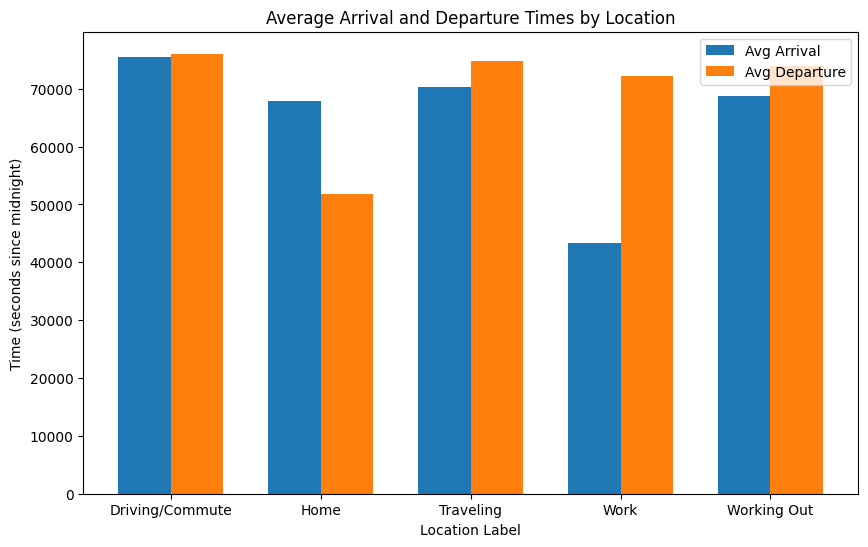

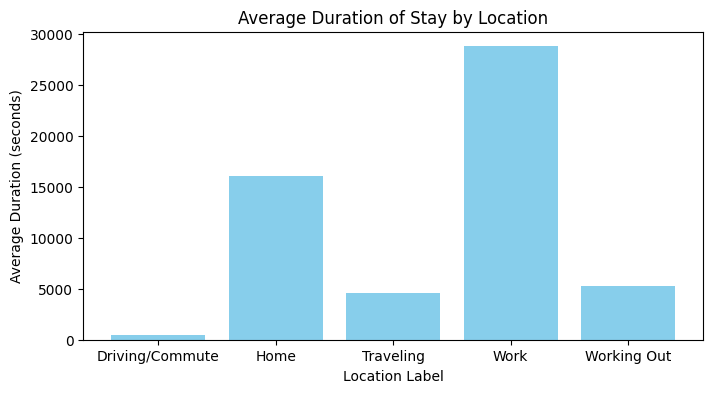

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose result is your DataFrame containing the columns:
# 'label', 'avg_arrival' (as "HH:MM:SS"), 'avg_departure' (as "HH:MM:SS"),
# and 'avg_duration' (as a timedelta)

# Function to convert time string (HH:MM:SS) to seconds since midnight
def time_to_seconds(time_str):
    h, m, s = map(int, time_str.split(':'))
    return h * 3600 + m * 60 + s

# Apply conversion to arrival and departure times
result['arrival_seconds'] = result['avg_arrival'].apply(time_to_seconds)
result['departure_seconds'] = result['avg_departure'].apply(time_to_seconds)

# If avg_duration is a timedelta, convert it to seconds
if pd.api.types.is_timedelta64_dtype(result['avg_duration']):
    result['duration_seconds'] = abs(result['avg_duration'].dt.total_seconds()) 
else:
    # If it's stored as a string or other format, you might need a conversion method.
    result['duration_seconds'] = abs(pd.to_timedelta(result['avg_duration']).dt.total_seconds())

# --- Grouped Bar Chart for Arrival and Departure Times ---

fig, ax = plt.subplots(figsize=(10, 6))
index = np.arange(len(result))
bar_width = 0.35

# Plot bars for average arrival and departure (in seconds since midnight)
bars1 = ax.bar(index, result['arrival_seconds'], bar_width, label='Avg Arrival')
bars2 = ax.bar(index + bar_width, result['departure_seconds'], bar_width, label='Avg Departure')

ax.set_xlabel('Location Label')
ax.set_ylabel('Time (seconds since midnight)')
ax.set_title('Average Arrival and Departure Times by Location')
ax.set_xticks(index + bar_width/2)
ax.set_xticklabels(result['label'])
ax.legend()

plt.show()

# --- Bar Chart for Average Duration ---

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(result['label'], result['duration_seconds'], color='skyblue')
ax.set_xlabel('Location Label')
ax.set_ylabel('Average Duration (seconds)')
ax.set_title('Average Duration of Stay by Location')
plt.show()

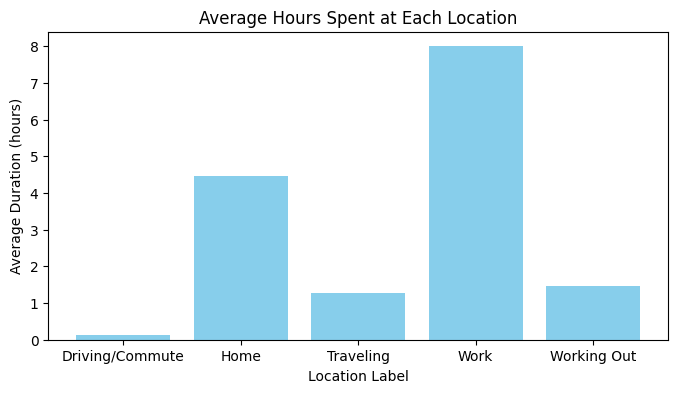

In [11]:
result['duration_hours'] = result['duration_seconds'] / 3600

# Convert duration to hours if not already done
if 'duration_hours' not in result.columns:
    if pd.api.types.is_timedelta64_dtype(result['avg_duration']):
        result['duration_hours'] = result['avg_duration'].dt.total_seconds() / 3600
    else:
        # If stored as seconds, convert to hours
        result['duration_hours'] = result['duration_seconds'] / 3600

# Plotting the average duration in hours
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(result['label'], result['duration_hours'], color='skyblue')
ax.set_xlabel('Location Label')
ax.set_ylabel('Average Duration (hours)')
ax.set_title('Average Hours Spent at Each Location')
plt.show()